# ISMN insitu data
This notebbok will extract the data from 2017 loading a .mat file and saving a ordered datasetructure, saved in a .h5 file

ABOUT THIS: 
- ISMN_2012_2020.mat (recomendable que lo abras con matlab antes de intentar 
la lectura en python) : Tienes de 2012 a 2020 datos in situ de SM (soil moisture) 
y TS (soil temperature) que es en este caso lo que te interesa. Piensa que con 
MODIS tendrás datos de temperatura de vegetación también, en este caso son 
datos de campo en donde hay sondas a 0-7 cm en el suelo, así que esto es 
exclusivamente suelo independientemente de la vegetación que haya. Hay más 
información de la que necesitas, pero básicamente es lo siguiente:

Son 1369 estaciones en 96432 momentos temporales (cuidado porque habría que 
refinar este "cubo" de datos para que cada columna fuera el mismo momento 
temporal, en este caso fíjate que no es así), tienes que irte a year, month, day y 
hour para identificar el momento temporal. Para identificar cuál es cada una de 
las estaciones tendrías que irte al archivo de node_info_t_2012_2020.mat.  En "
value" tienes el valor de la temperatura en K, y en "quality_flag", si es 1, 
podrás usar el dato, en caso contrario lo desechas.

- node_info_t_2012_2020.mat: Tienes campos que te permiten ubicar cada uno de 
los píxeles, te interesan especialmente rowsL3 y columnsL3 porque son los que 
identifican en qué pixel de la matriz de la malla EASE2 (de AMSR2) es donde 
estaría contenida la estación in situ (¡ojo! comprueba con "longitudes" y "
latitudes" que haces el match bien con AMSR2). Podremos asumir inicialmente que una 
estación in situ sea representativa del pixel entero en la malla EASE2. El resto 
de información de momento no la vas a necesitar.

#### The datafiles are complicated to open in python, maybe i can preprocess stuff in matlab then get the 2017 data and loaded here

Lets open matlab, load the objects and save them into a .nc file...

In [2]:
# Libraries
# import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

import xarray as xr
from datetime import datetime

# Custom functions

# Global variables

In [3]:
# TODO: This function does not work as expected, all years selected are later than 2017
# Only Local
path = "../data/raw/ISMN_2012_2020.mat"

f = h5py.File(path, "r")
data = f.get("ISMN")
ts_data = data.get("TS")

ts_dict = {}
for key, value in ts_data.items():
    if key in ["year", "day", "month", "hour"]:
        print(f"loading {key}")
        ts_dict[key] = value[:]

loading day
loading hour
loading month
loading year


In [4]:
# Sanity check
for key, value in ts_dict.items():
    print(key, ts_dict[key].shape, str(ts_dict[key][10][42]), ts_dict[key].dtype)

day (96432, 1369) 17.0 float64
hour (96432, 1369) 10.0 float64
month (96432, 1369) 6.0 float64
year (96432, 1369) 2020.0 float64


In [5]:
# Retype the fields that do not need to be float64

# Field names : new missing values, since NaN is a float in numpy
changes = {"day": -1, "month": -1, "hour": -1, "year": -1}

for key, value in changes.items():
    ts_dict[key] = np.nan_to_num(ts_dict[key], nan=value).astype(np.intc)

In [6]:
# Sanity check
for key, value in ts_dict.items():
    print(key, ts_dict[key].shape, ts_dict[key].dtype)

day (96432, 1369) int32
hour (96432, 1369) int32
month (96432, 1369) int32
year (96432, 1369) int32


In [18]:
# Store variables in a much more efficient format
"""
    Take the doy + year + hour and transform it into a date format string YYYY-MM-DDThh:mm:ss, then into timestampo float
    (seconds since 1970-01-01T00:00:00)
"""
# Time variables
years = ts_dict["year"]
day = ts_dict["day"]
month = ts_dict["month"]
hours = ts_dict["hour"]

combined_timestamps = np.empty_like(years, dtype=float)

for i in range(years.shape[0]):
    for j in range(years.shape[1]):
        try:
            # Create a datetime object
            dt_obj = datetime(years[i, j], month[i, j], day[i, j], hours[i, j], 0, 0)

            # Convert to timestamp and store
            combined_timestamps[i, j] = dt_obj.timestamp()
        except:
            # Set a default timestamp for invalid values
            combined_timestamps[i, j] = 0.0

print(combined_timestamps[0, 0], combined_timestamps.shape)

1592344800.0 (96432, 1369)


In [20]:
# Save the string array to a HDF5 file
date_file_path = "../data/output/combined_timestamp_2017.h5"

try:
    if combined_timestamps.any():
        # Create an HDF5 file
        with h5py.File(date_file_path, "w") as file:
            # Create a dataset and store the NumPy array in it
            dataset = file.create_dataset(
                "date", combined_timestamps.shape, dtype=float
            )
            dataset[...] = combined_timestamps

        # Delete the timestamp object to save RAM
        del combined_timestamps
except NameError:
    print("No combined timestamp object")

In [10]:
# Now we load the node info in the other file

path = "../data/raw/node_info_t_2012_2020.mat"
nodeinfo = scipy.io.loadmat(path)

for key, value in nodeinfo.items():
    print(key, "->>", nodeinfo[key])

nodeinfo = nodeinfo["node_info_t"][0][0]

__header__ ->> b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Apr 26 21:51:13 2021'
__version__ ->> 1.0
__globals__ ->> []
node_info_t ->> [[(array([[37.2134 ],
         [37.2134 ],
         [37.2134 ],
         ...,
         [32.835  ],
         [52.43229],
         [52.43239]]), array([[ -98.0969 ],
         [ -98.0969 ],
         [ -98.0969 ],
         ...,
         [-114.1884 ],
         [  -4.02063],
         [  -4.02158]]), array(['ARM        ', 'ARM        ', 'ARM        ', ..., 'USCRN      ',
         'WSMN       ', 'WSMN       '], dtype='<U11'), array([[array(['ARM\\Anthony'], dtype='<U11')],
         [array(['ARM\\Anthony'], dtype='<U11')],
         [array(['ARM\\Anthony'], dtype='<U11')],
         ...,
         [array(['USCRN\\Yuma-27-ENE'], dtype='<U17')],
         [array(['WSMN\\WSMN-1'], dtype='<U11')],
         [array(['WSMN\\WSMN-2'], dtype='<U11')]], dtype=object), array([[469],
         [469],
         [469],
         ...,
         [451],
         [525],
  

In [15]:
# Take the relevant fields
nodelat = nodeinfo[0]
nodelong = nodeinfo[1]
nodetag = nodeinfo[2]
# nodetagname = nodeinfo[3]
nodename = nodeinfo[8]
nodeid = [i for i in range(nodeinfo[0].shape[0])]

lat = [nodelat.tolist()[i][0] for i in range(nodelat.shape[0])]
lon = [nodelong.tolist()[i][0] for i in range(nodelat.shape[0])]
tags = [nodetag[i].strip() for i in range(nodetag.shape[0])]
names = [nodename[i].strip() for i in range(nodename.shape[0])]

node_dict = {
    "nodeid": nodeid,
    "node_latitude": lat,
    "node_longitude": lon,
    "node_tag": tags,
    "node_name": names,
}

# Save it into a CSV/DataFrame for easy access
nodes_df = pd.DataFrame.from_dict(node_dict)

nodeinfo_path = "../data/outputde_info.csv"

nodes_df = pd.DataFrame.from_dict(node_dict)
print(nodes_df.shape)
nodes_df.to_csv(nodeinfo_path)
nodes_df.head()

(1369, 5)


,nodeid,node_latitude,node_longitude,node_tag,node_name
0,0,37.2134,-98.0969,ARM,ARM\Anthony
1,1,37.2134,-98.0969,ARM,ARM\Anthony
2,2,37.2134,-98.0969,ARM,ARM\Anthony
3,3,37.1330,-97.2660,ARM,ARM\Ashton
4,4,37.1330,-97.2660,ARM,ARM\Ashton


----


In [21]:
# Load prerpocesed data
nodeinfo_path = "../data/output/node_info.csv"
date_file_path = "../data/output/combined_timestamp_2017.h5"
TS_path = "../data/raw/ISMN_2012_2020.mat"

print("Loading Dates")
#  Read the combined dates from the HDF5 file
with h5py.File(date_file_path, "r") as file:
    dates = file["date"][:].T
    # decoded_dates = np.array([x.decode('utf-8') for x in dates]).reshape(dates.shape)
print(dates.shape, "DONE")

# Read the TS values from the original dataset
print("Loading TS values and quality flags")
with h5py.File(TS_path, "r") as file:
    data = file.get("ISMN")
    ts_data = data.get("TS")
    ts_values = ts_data["value"][:].T
    qflags = ts_data["quality_flag"][:].T

print(ts_values.shape, qflags.shape, "DONE")

# Read the node metadata
print("Loading node information")
nodeinfo_df = pd.read_csv(nodeinfo_path)
print(nodeinfo_df.shape, "DONE")

Loading Dates
(1369, 96432) DONE
Loading TS values and quality flags
(1369, 96432) (1369, 96432) DONE
Loading node information
(1369, 6) DONE


In [23]:
# We can mask the array with only the cells that contain data from year 2017
from datetime import datetime

start_date = datetime(2017, 1, 1, 0, 0, 0).timestamp()
end_date = datetime(2017, 12, 31, 23, 0, 0).timestamp()

in_2017 = np.array([start_date < date < end_date for date in dates.flatten()]).reshape(
    dates.shape
)

In [24]:
# Create an Xarray object with the specified dimentions:
"""
FROM:
        - Date (1369, 96432) : string representing np.datetime64 objects
        - TS values
        - node metadata

TO:
    Data variables:
        - TS value (1369, 96432) : float64
        - Quality Flag (1369, 96432) : class [1, 0, nan]
        - 2017 mask (1369, 96432): bool
        - Timestamp (1369, 96432): datetime.timestamp
    Dimentions :
        + The station identification / (latitude, longitude)
            - Latitude (1369, )
            - Longitude (1369, )
            - Station (1369, )
        - Datepoint index (96432)
"""


ISMN_dataset = xr.Dataset(
    coords={
        "Node_name": nodeinfo_df["node_name"],
        "Register": [i for i in range(dates.shape[1])],
    }
)


# Filter the data variables for date  in ["2017-01-01T00:00:00" to "2017-12-31T23:00:00"] (hour-sized steps)


# Save the 2017 object as a HDF5 file:


ISMN_dataset["values"] = (["Node_name", "Register"], ts_values)
ISMN_dataset["quality_flag"] = (["Node_name", "Register"], qflags)

ISMN_dataset["timestamp"] = (["Node_name", "Register"], dates)
ISMN_dataset["2017_mask"] = (["Node_name", "Register"], in_2017)

ISMN_dataset["lat"] = (["Node_name"], nodeinfo_df["node_latitude"])
ISMN_dataset["lon"] = (["Node_name"], nodeinfo_df["node_longitude"])
ISMN_dataset["node_tag"] = (["Node_name"], nodeinfo_df["node_tag"])

In [25]:
ISMN_dataset

<xarray.Dataset>
Dimensions:       (Node_name: 1369, Register: 96432)
Coordinates:
  * Node_name     (Node_name) object 'ARM\\Anthony' ... 'WSMN\\WSMN-2'
  * Register      (Register) int64 0 1 2 3 4 5 ... 96427 96428 96429 96430 96431
Data variables:
    values        (Node_name, Register) float64 297.8 297.5 297.3 ... 0.0 0.0
    quality_flag  (Node_name, Register) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    timestamp     (Node_name, Register) float64 1.592e+09 1.592e+09 ... 0.0 0.0
    2017_mask     (Node_name, Register) bool False False False ... False False
    lat           (Node_name) float64 37.21 37.21 37.21 ... 32.84 52.43 52.43
    lon           (Node_name) float64 -98.1 -98.1 -98.1 ... -114.2 -4.021 -4.022
    node_tag      (Node_name) object 'ARM' 'ARM' 'ARM' ... 'USCRN' 'WSMN' 'WSMN'

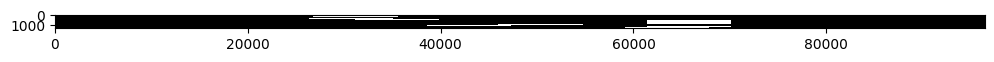

In [27]:
boolean_mask = ISMN_dataset["2017_mask"]

plt.figure(figsize=(12, 12))
plt.imshow(boolean_mask, cmap="gray", interpolation="nearest")
plt.show()

In [28]:
# Save the xarray object into a single file
ISMN_dataset_path = "../data/output/ISMN_dataset.h5"
ISMN_dataset.to_netcdf(ISMN_dataset_path)